In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import stats
from scipy.interpolate import UnivariateSpline
#Single mammalian cell biomass: 264pg/cell. Ref: https://doi.org/10.1016/j.ymben.2020.06.002 

In [2]:
def add_linear(ax, xdata, ydata):
    def func(x, a, b):
        return a * x + b
    popt, pcov = curve_fit(func, xdata, ydata)
    temp_x = np.linspace(min(xdata),max(xdata) )
    ax.plot(temp_x, func(temp_x, *popt),'r--')
    
def get_pv(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return pv

def get_pcc(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return coeff

In [3]:
data=pd.read_csv('../data/exp_data/CultureData.csv')
data=data.rename(columns={'Biomass_avg(g/L)':'Biomass_avg','Biomass_std(g/L)':'Biomass_std'})
pH_measure=pd.read_csv('../data/exp_data/CulturepH.csv')

Text(0.5, 0, 'Time(hr)')

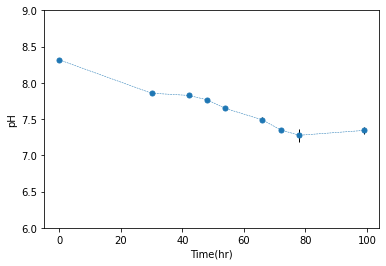

In [4]:
fig,ax=plt.subplots(1,1)
ax.errorbar(pH_measure.Time, pH_measure.pH_avg,yerr=  pH_measure.pH_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1)
ax.set_ylim([6,9])
ax.set_ylabel('pH'); ax.set_xlabel('Time(hr)')

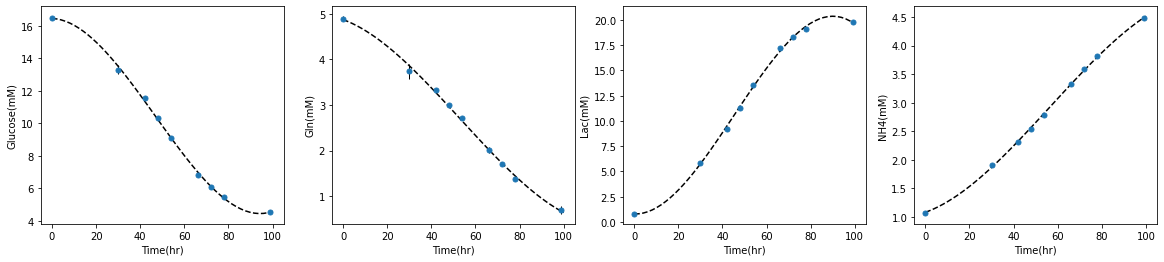

In [22]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
ynames=['Glucose','Gln','Lac','NH4']
for i in range(4):
    spline = UnivariateSpline(data.Time, data[ynames[i]+'_avg']) 
    axs[i].errorbar(data.Time,data[ynames[i]+'_avg'],yerr= data[ynames[i]+'_std'], ecolor='black',
                      marker='o', markersize=5, linestyle='',elinewidth=1)
    temp_T=np.linspace(0,100)
    axs[i].plot(temp_T, spline(temp_T), color='black',linestyle='--')
    axs[i].set_xlabel('Time(hr)')
    axs[i].set_ylabel(ynames[i]+'(mM)')

In [59]:
# def get_grs(biomass, time_pts):
#     output = []
#     for i in range(len(biomass)-1):
#         output.append( np.log(biomass[i+1]/biomass[i]) /(time_pts[i+1]-time_pts[i]) )
#     return output  

# def norm_rates(biomass, cons, time_pts):
#     output = []
#     for i in range(len(biomass)-1):
#         output.append( ((cons[i+1]-cons[i])/(biomass[i]/2+biomass[i+1]/2) )/(time_pts[i+1]-time_pts[i]) )
#     return output

def approx_rates(biomass, cons, time_pts):
    biomass_spline= UnivariateSpline(time_pts, biomass)
    cons_spline=UnivariateSpline(time_pts, cons)
    cons_grad = cons_spline.derivative(1)
    temp_T=np.linspace(0,100)
    rates = [ cons_grad(t)/biomass_spline(t) for t in temp_T]
    return rates

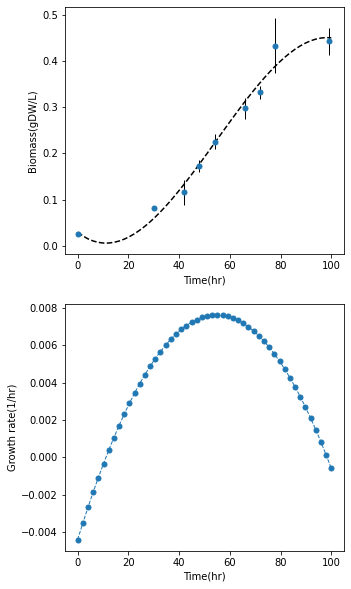

In [52]:
fig, axs = plt.subplots(2,1,figsize=(5,10))
biomass_spline= UnivariateSpline(data.Time, data.Biomass_avg) 
axs[0].errorbar(data.Time,data.Biomass_avg,yerr= data.Biomass_std, ecolor='black',
                      marker='o', markersize=5, linestyle='', linewidth=0.5, elinewidth=1);
temp_T=np.linspace(0,100)
axs[0].plot(temp_T, biomass_spline(temp_T), color='black',linestyle='--')
axs[0].set_ylabel('Biomass(gDW/L)')
grs=biomass_spline.derivative(1)
axs[1].plot(temp_T, grs(temp_T),marker='o', markersize=5, linestyle='--', linewidth=1)
axs[1].set_ylabel('Growth rate(1/hr)')
for ax in axs:
    ax.set_xlabel('Time(hr)')

In [99]:
# Ts= [data.Time[i]/2+data.Time[i+1]/2 for i in range(len(data.Time)-1)]
# grs=get_grs(data.Biomass_avg, data.Time)
gr_rates = grs(temp_T)
approx_results = pd.DataFrame(zip(np.linspace(0,100),gr_rates),columns=['Time','gr'])
mets=['Glucose','Gln','Lac','NH4']
for met in mets:
    approx_results[met+'_rate']=approx_rates(data.Biomass_avg, data[met+'_avg'], data.Time)
approx_results = approx_results[(approx_results['Time']>12) & (approx_results['Time']<90)].reset_index().drop(['index'],axis=1)

In [100]:
approx_results.head()

,Time,gr,Glucose_rate,Gln_rate,Lac_rate,NH4_rate
0,12.244898,0.004884,-13.682796,-4.917048,22.907131,3.810494
1,14.285714,0.005176,-12.616843,-4.266037,21.388146,3.305306
2,16.326531,0.005452,-10.322631,-3.327671,17.656243,2.578368
3,18.367347,0.005712,-8.156126,-2.531258,14.042251,1.961776
4,20.408163,0.005956,-6.474124,-1.948784,11.200489,1.511000


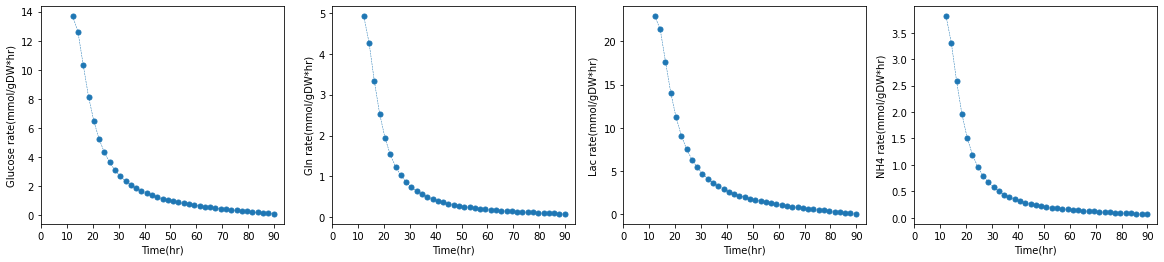

In [101]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
ynames=['Glucose','Gln','Lac','NH4']
for i in range(4):
    if i <2:
        y=(-1)*approx_results[ynames[i]+'_rate']
    else:
        y=approx_results[ynames[i]+'_rate']
    axs[i].plot(approx_results.Time, y,marker='o', markersize=5, linestyle='--', linewidth=0.5)
    axs[i].set_xlabel('Time(hr)')
    axs[i].set_xticks(np.arange(0,100,10))
    axs[i].set_ylabel(ynames[i]+' rate(mmol/gDW*hr)')

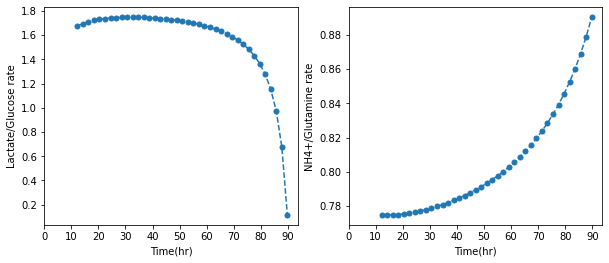

In [102]:
fig,axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(approx_results.Time,-1*approx_results.Lac_rate/approx_results.Glucose_rate,marker='o', markersize=5, linestyle='--')
axs[0].set_ylabel('Lactate/Glucose rate')
axs[1].plot(approx_results.Time,-1*approx_results.NH4_rate/approx_results.Gln_rate,marker='o', markersize=5, linestyle='--')
axs[1].set_ylabel('NH4+/Glutamine rate')
for ax in axs:
    ax.set_xlabel('Time(hr)')
    ax.set_xticks(np.arange(0,100,10))

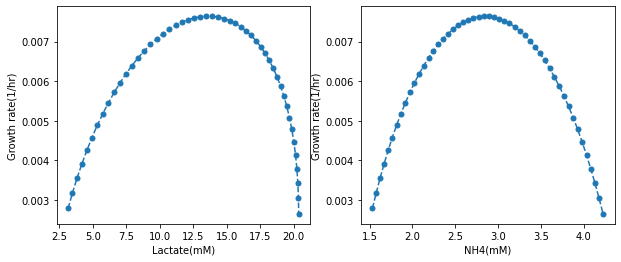

In [103]:
fig,axs=plt.subplots(1,2,figsize=(10,4))
temp_T=np.linspace(20,90)
lac_spline = UnivariateSpline(data.Time, data.Lac_avg)
nh4_spline = UnivariateSpline(data.Time, data.NH4_avg)
gr_rates = grs(temp_T)

axs[0].plot(lac_spline(temp_T),gr_rates,marker='o', markersize=5, linestyle='--')
axs[1].plot(nh4_spline(temp_T),gr_rates,marker='o', markersize=5, linestyle='--')
for ax in axs:
    ax.set_ylabel('Growth rate(1/hr)')
axs[0].set_xlabel('Lactate(mM)'); axs[1].set_xlabel('NH4(mM)');

In [106]:
ATP_approx=[]
for i in range(len(approx_results.index)):
    lac_r=approx_results.Lac_rate[i];glc_r=(-1)*approx_results.Glucose_rate[i];
    gln_r=(-1)*approx_results.Gln_rate[i];
    ATP_approx.append( lac_r + (glc_r-lac_r/2)*30 + gln_r*22.5 )
approx_results['ATP_estimated']=ATP_approx

In [109]:
def func(x, a, b):
    return a * x + b
popt, pcov = curve_fit(func, approx_results.gr[5:30],approx_results.ATP_estimated[5:30])
print(popt)

[-26798.59219207    212.48225011]


0.8089400937810812


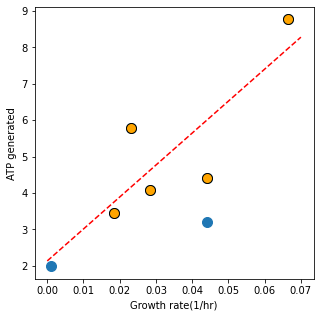

In [17]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(growth_data.gr[1:],growth_data.ATP_estimated[1:],s=100)
ax.scatter(growth_data.gr[1:6],growth_data.ATP_estimated[1:6],color='orange',s=100,edgecolor='black')
ax.set_ylabel('ATP generated')
ax.set_xlabel('Growth rate(1/hr)')
temp_x = np.linspace(0,0.07)
ax.plot(temp_x, func(temp_x, *popt),'r--')
y_pred = [func(x, 87.8, 2.13) for x in growth_data.gr[1:6]]
print( get_pcc(growth_data.ATP_estimated[1:6],y_pred) )